In [ ]:
# CELL 1 (do not change)
"""import statements and boiler plate code"""
import tensorflow_datasets as tfds
import tensorflow as tf 
import tensorflow.keras as ks
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

from typing import *
import sys

if sys.version_info >= (3, 8, 0):
    from math import prod
else:
    # math.prod shim for Python 3.7 and older
    def prod(iterable, *, start=1):
        total = start
        for element in iterable:
            total *= element
        return (total)

def pretruberate(latent, model, bit, value):
    if not isinstance(latent, np.ndarray):
        latent = latent.numpy()
    latent[0][bit] = step
    return model.decode(latent)

def pretruberate_range(latent, image, model, bit, vals):
    fig, ax = plt.subplots(1, 11)
    fig.set_size_inches(w = 15, h = 30)
    for i, step in enumerate(vals):
        rec = pretruberate(latent, model, bit, step)
        ax[i].imshow(rec[0, :, :, 0])
        ax[i].axis('off')
    ax[10].imshow(image[0, :, :, 0])
    ax[10].axis('off')
    plt.show()
    pass

def get_sample(val, index, model, batch_size = None):
    sample = val.skip(index).take(1)
    for image, label in sample:
        break
    if batch_size is None:
        latent = model.predict(image).numpy()
    else:
        latent = model.predict(image, batch_size = batch_size).numpy()
    return image, latent


def display(val, model, n = 10, x0 = 0, y0 = 1): 
    image, latent = get_sample(val, 11, model)
    latent = model.predict(image).numpy()
    latent = latent[0, :]
    print(latent.shape)
    norm = tfp.distributions.Normal(0,1)
    vals_x = norm.quantile(np.linspace(0.05, 0.95, n))
    vals_y = norm.quantile(np.linspace(0.05, 0.95, n))

    fig, ax = plt.subplots(n, n)
    fig.set_size_inches(w = 10, h = 10)
    for i, x in enumerate(vals_x):
        for j, y in enumerate(vals_y):
            latent[x0], latent[y0] = x, y
            rec = tf.sigmoid(model.decode(np.array([latent])))
            ax[i, j].imshow(rec[0,:,:,0], cmap='gnuplot2')
            ax[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()
    pass

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

random value:  27
random value:  28


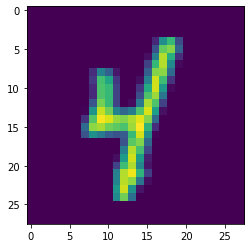

random value:  26


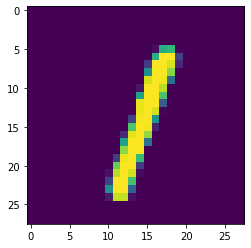

random value:  28


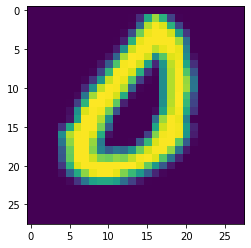

random value:  28


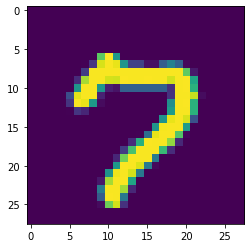

random value:  26


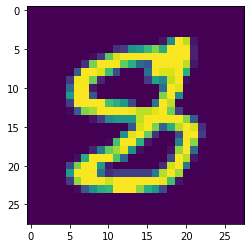

random value:  28


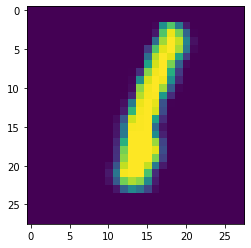

random value:  27


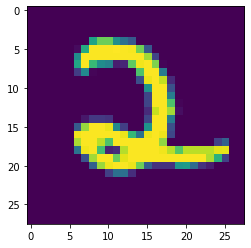

random value:  28


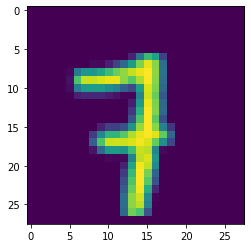

random value:  27


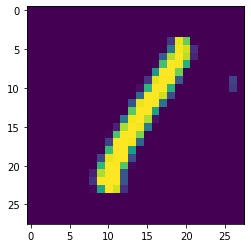

random value:  28


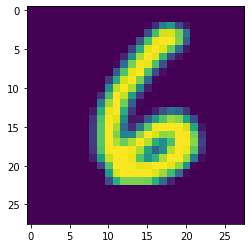

random value:  28


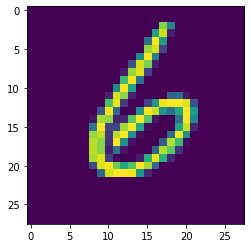

random value:  27


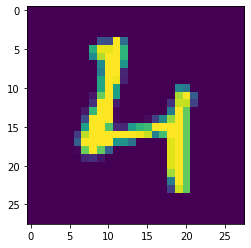

In [ ]:
# CELL 2
def preprocess(image: tf.Tensor, label: tf.Tensor, disp: bool = False):
    # TODO: fill in this function
    preprocessed_image = tf.cast(image, dtype=tf.float32) # cast image to a float32 tensor
    preprocessed_image = preprocessed_image / 255 # scaling all values to be between 0 and 1
    randint = tf.py_function(np.random.randint, [26, 29], tf.int32) # generating a random number between 26 and 28
    preprocessed_image = tf.image.random_crop(preprocessed_image, size=(randint, randint, 1)) # applying a random crop
    preprocessed_image = tf.image.resize(preprocessed_image, size=(28, 28)) # resizing the image to (28, 28, 1)
    
    if disp:
        tf.print("random value: ", randint)
    return preprocessed_image, preprocessed_image

"""script to load data set and print info"""
(train, test), info = tfds.load("mnist", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
print(info)

""" Test """
train = train.map(lambda x, y: preprocess(x, y, disp = True)).batch(1)
for i, (image, _) in enumerate(train):
    plt.imshow(image[0, ..., 0])
    plt.show()
    if i > 10:
        break

In [ ]:
# CELL 3
""" Custom Building Blocks """
class ResidualBlock(ks.layers.Layer):
    def __init__(self, 
                 filters: int, 
                 dilation_rate: Tuple[int, int] = (1,1), 
                 kernel_initializer: str = 'glorot_uniform', 
                 momentum: float = 0.99, 
                 epsilon: float = 0.001, 
                 downsample: bool = False,
                 use_bias: bool = False, 
                 use_sync: bool = True, 
                 kernel_regularizer = None, 
                 bias_regularizer = None):
        
        # parameters Conv2D
        self._filters = filters
        self._dilation_rate = dilation_rate
        self._kernel_initializer = kernel_initializer
        self._kernel_regularizer = kernel_regularizer
        self._bias_regularizer = bias_regularizer
        self._use_bias = use_bias
        self._use_sync = use_sync

        # parameters Batch Norm
        if K.image_data_format() == "channels_last":
            # channels_last: (batch_size, height, width, channels)
            self._axis = -1
        else:
            # not channels_last: (batch_size, channels, height, width)
            self._axis = 1

        self._momentum = momentum 
        self._epsilon = epsilon 

        # downsample
        self._downsample = downsample

        if downsample:
            self._strides = (2,2)
        else:
            self._strides = (1,1)

        # TODO: set the activation function to the same one that is used in the paper
        self._activation = ks.activations.relu

        super(ResidualBlock, self).__init__()

    def build(self, ishape):
        # TODO: fill in this function
        # raise NotImplementedError
        self._maxpool = ks.layers.MaxPool2D(
          pool_size=(2, 2), 
          strides=self._strides, 
          padding="same",
          data_format=None
        )

        self._conv1 = ks.layers.Conv2D(
            filters=self._filters,
            kernel_size=(3,3),
            strides=self._strides,
            padding="same",
            # data_format=K.image_data_format(),
            dilation_rate=self._dilation_rate,
            activation=self._activation,
            use_bias=self._use_bias,
            kernel_initializer=self._kernel_initializer,
            kernel_regularizer=self._kernel_regularizer,
            bias_regularizer=self._bias_regularizer
        )
        
        self._conv2 = ks.layers.Conv2D(
            filters=self._filters,
            kernel_size=(3,3),
            strides=self._strides,
            padding="same",
            # data_format=K.image_data_format(),
            dilation_rate=self._dilation_rate,
            activation=self._activation,
            use_bias=self._use_bias,
            kernel_initializer=self._kernel_initializer,
            kernel_regularizer=self._kernel_regularizer,
            bias_regularizer=self._bias_regularizer
        )

        self._conv = ks.layers.Conv2D(
            filters=self._filters,
            kernel_size=(1,1),
            strides=self._strides,
            padding="same"
        )
        
        self._bn1 = ks.layers.BatchNormalization(
            axis=self._axis, 
            momentum=self._momentum, 
            epsilon=self._epsilon
        )

        self._bn2 = ks.layers.BatchNormalization(
            axis=self._axis, 
            momentum=self._momentum, 
            epsilon=self._epsilon
        )

        super(ResidualBlock, self).build(ishape)

    def call(self, inputs):
        # TODO: fill in this function
        # raise NotImplementedError
        if not(self._downsample):
          self._x_skip = inputs
        else:
          self._x_skip = self._maxpool(self._conv(inputs))

        x = self._conv1(inputs) 
        x = self._bn1(x)
        x = self._activation(x)
        x = self._conv2(x)
        x = self._bn2(x)
        x = x + self._x_skip
        return self._activation(x)

"""Testing"""
vis = train.take(10)
for image, t in vis:
    x = ResidualBlock(filters = 3)(image)
    y = ResidualBlock(filters = 32, downsample=True)(image)
    print(x.shape, y.shape)

random value:  26
random value:  28
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  28
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  26
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  28
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  28
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  27
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  27
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  27
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  27
(1, 28, 28, 3) (1, 7, 7, 32)
random value:  27
(1, 28, 28, 3) (1, 7, 7, 32)


(10, 10, 2)
Epoch 1/20
1500/1500 [==============================] - 65s 42ms/step - loss: 768.9934 - mean_squared_error: 23.4806 - loss2: -219.8607 - reg: 0.2323 - val_loss: 4.0706 - val_mean_squared_error: 29.6208
Epoch 2/20
1500/1500 [==============================] - 58s 38ms/step - loss: 201.2309 - mean_squared_error: 31.9536 - loss2: -196.2289 - reg: 0.9861 - val_loss: 4.4828 - val_mean_squared_error: 35.3753
Epoch 3/20
1500/1500 [==============================] - 57s 38ms/step - loss: 196.9773 - mean_squared_error: 33.1073 - loss2: -192.1004 - reg: 1.1664 - val_loss: 4.6191 - val_mean_squared_error: 36.9385
Epoch 4/20
1500/1500 [==============================] - 56s 37ms/step - loss: 193.9462 - mean_squared_error: 34.2755 - loss2: -189.0984 - reg: 1.2943 - val_loss: 4.6367 - val_mean_squared_error: 36.9862
Epoch 5/20
1500/1500 [==============================] - 56s 38ms/step - loss: 191.6673 - mean_squared_error: 35.1605 - loss2: -186.8520 - reg: 1.3562 - val_loss: 4.6420 - val_m

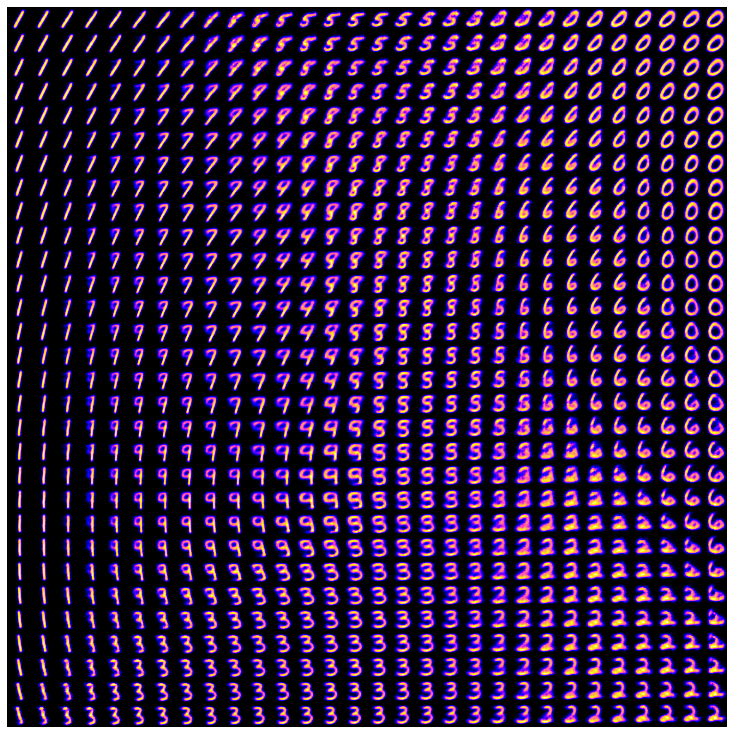

In [ ]:
# CELL 4
'''
testing your pipeline and you custom block together 

mnist input shape  = (28, 28, 1)

DEEP MIND Implementation -> very stable
 -> loss function is more stable 
 -> batch norm causes exploding gradients 
'''

@tf.function
def ae_loss(x, x_reconstruction, loss = ks.losses.mse):
    return -tf.reduce_sum(loss(x, x_reconstruction), axis = [1, 2, 3])

@tf.function
def regularize(z, mu, log_sigma):
    # mu = tf.reduce_sum(mu, axis = [1])
    # sigma = tf.reduce_sum(sigma, axis = [1])
    # term = tf.math.exp(sigma) + (mu ** 2) - 1 - sigma
    log2pi = tf.math.log(2. * np.pi)
    term = -0.5 * (((z - mu) ** 2.) * tf.math.exp(-log_sigma) + log_sigma + log2pi)
    return tf.reduce_sum(term, axis = 1)

@tf.function
def vae_loss(term1, term2):
    return -tf.reduce_mean(term1 + term2)

class VAE(ks.Model):
    def __init__(self, input_shape, latent_size = None, latent_dims = None, batch_size = 40):
        super(VAE, self).__init__()
        self.ishape = input_shape
        self.latent_size = latent_size
        self.batch_size = batch_size
        self.encoder = None
        self.decoder = None

        print(latent_dims)
        self.encoder = self.get_encoder(latent_size)
        self.decoder = self.get_decoder(latent_dims)
        return
    
    def get_encoder(self, latent_size):
        '''
        NOTE
        ----
        the encoder is a simple NN, CNN, RNN, or transformer structure that maps to a latent vector
        the details of the network do not need to be specific, but can be anything
        the attributes of this network:
            - downsample the input vector 
            - map to a vector
        '''
        encoder = ks.Sequential()
        encoder.add(ks.layers.Conv2D(32, kernel_size = (3,3), strides = (1,1), padding = "valid"))
        encoder.add(ks.layers.BatchNormalization())
        encoder.add(ks.layers.ReLU())
        encoder.add(ResidualBlock(64, downsample=True))
        encoder.add(ks.layers.Flatten())
        encoder.add(ks.layers.Dense(512))
        encoder.add(ks.layers.BatchNormalization())
        encoder.add(ks.layers.ReLU())

        # use latent_size + latent_size, so that half the vector is learing the z_mu (mean) other half is learning z_sigma (standard deviation)
        encoder.add(ks.layers.Dense(latent_size + latent_size))
        return encoder
    
    def get_decoder(self, dimension):
        vec_size = prod(dimension)
        decoder = ks.Sequential()
        decoder.add(ks.layers.Dense(vec_size))
        decoder.add(ks.layers.ReLU())
        decoder.add(ks.layers.Reshape(dimension, input_shape = (None, self.latent_size, )))
        decoder.add(ks.layers.Conv2DTranspose(64, kernel_size = (3,3), strides = (1,1), padding = "valid"))
        decoder.add(ks.layers.ReLU())
        decoder.add(ks.layers.Conv2DTranspose(64, kernel_size = (3,3), strides = (2,2), padding = "valid"))
        decoder.add(ks.layers.ReLU())
        decoder.add(ks.layers.Conv2DTranspose(32, kernel_size = (3,3), strides = (1,1), padding = "valid"))
        decoder.add(ks.layers.ReLU())
        decoder.add(ks.layers.Conv2DTranspose(1, kernel_size = (2,2), strides = (1,1), padding = "valid"))
        return decoder

    def reparameterize(self, z_mu, z_sigma):
        sample = tf.random.normal(shape = (self.batch_size, z_mu.shape[-1]), mean = 0, stddev=1)
        z = z_mu + tf.math.exp(z_sigma) * sample
        return z

    def decode(self, inputs):
        self.batch_size = tf.shape(inputs)[0]
        x = self.decoder(inputs)
        return x

    def call(self, inputs):
        self.batch_size = tf.shape(inputs)[0]
        z_full = self.encoder(inputs)

        # num_or_size_splits is a scalar to the value gets split evenly in the same way every time
        z_mu, z_sigma = tf.split(z_full, num_or_size_splits=2, axis = -1)
        z = self.reparameterize(z_mu, z_sigma)
        x = self.decoder(z)
        return x, z, z_mu, z_sigma

    def predict(self, inputs):
        self.batch_size = tf.shape(inputs)[0]
        z_full = self.encoder(inputs)
        z_mu, z_sigma = tf.split(z_full, num_or_size_splits=2, axis = -1)
        z = self.reparameterize(z_mu, z_sigma)
        return z

    def train_step(self, data):
        # use with model.fit
        # unpack the input data
        x, x_reconstruction = data

        with tf.GradientTape() as tape:
            # call self or model to make a prediction
            x_hat, z, z_mu, z_sigma = self(x, training = True)
            p_xz = ae_loss(x, x_hat, loss = tf.nn.sigmoid_cross_entropy_with_logits) # computes sigmoid for you 
            p_z = regularize(z, 0., 0.)
            q_zx = regularize(z, z_mu, z_sigma)
            loss = self.compiled_loss(p_xz, p_z - q_zx , regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(x, x_hat)
        ret = {m.name: m.result() for m in self.metrics}
        ret.update({"loss2": p_xz, "reg": q_zx})
        return ret
    


EPOCHS = 20
BATCH_SIZE = 80
LATENT_SIZE = 2
loss = vae_loss
optimizer = ks.optimizers.Adam()
printing = False
losses = []

    
(train, test), info = tfds.load("mnist", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
train = train.map(lambda x, y: preprocess(x, y)).batch(40)
test = test.map(lambda x, y: preprocess(x, y)).batch(1)

# if the output looks blurry, increase the epochs or comment out the randome crops. 
# we will still use random crops to test that the data pipeline is functional, so dont delete it
# if you comment it out, in the machine learning question google doc, just leave a 
# note for this part indicating that you choose to comment out the random crops
# commenting it out will not affect your possition on the team

model = VAE(input_shape=(28,28,1), latent_size = LATENT_SIZE, latent_dims = (10,10,2))
model.compile(loss=loss, optimizer=optimizer, metrics = [tf.keras.metrics.MeanSquaredError()])
epoch_data = model.fit(train, epochs=EPOCHS, validation_data=test)

# if you dont want to train again, just this in a new cell
display(test, model, x0 = 0, y0 = 1, n = 30)

In [ ]:
#CELL 5
"""
write the loss function
"""

@tf.function
def ae_loss(x, x_reconstruction, mu, log_sigma, batch_size, latent_size):
    """
    Answers to requested questions for this code block, questions can be found
    on the google doc associated with this assignment. Godspeed. 

    To re-iterate the instruction doc: This step is not required, but it will be
    extra-credit for the competition (see step 7).
    """
    # TODO: fill in this function
    raise NotImplementedError

class VAE(ks.Model):
    def __init__(self, input_shape, latent_size = None, latent_dims = None, batch_size = 40):
        super(VAE, self).__init__()
        self.ishape = input_shape
        self.latent_size = latent_size
        self.batch_size = batch_size
        self.encoder = None
        self.decoder = None

        self.encoder = self.get_encoder(latent_size)
        self.decoder = self.get_decoder(latent_dims)

        print(latent_dims)
        return
    
    def get_encoder(self, latent_size):
        '''
        NOTE
        ----
        the encoder is a simple NN, CNN, RNN, or transformer structure that maps to a latent vector
        the details of the network do not need to be specific, but can be anything
        the attributes of this network:
            - downsample the input vector 
            - map to a vector
        '''
        encoder = ks.Sequential()
        encoder.add(ks.layers.Conv2D(32, kernel_size = (3,3), strides = (1,1), padding = "valid"))
        encoder.add(ks.layers.BatchNormalization())
        encoder.add(ks.layers.ReLU())
        encoder.add(ResidualBlock(64, downsample=True))
        encoder.add(ks.layers.Flatten())
        encoder.add(ks.layers.Dense(512))
        encoder.add(ks.layers.BatchNormalization())
        encoder.add(ks.layers.ReLU())

        # use latent_size + latent_size, so that half the vector is learing the z_mu (mean) other half is learning z_sigma (standard deviation)
        encoder.add(ks.layers.Dense(latent_size + latent_size))
        return encoder
    
    def get_decoder(self, dimension):
        vec_size = prod(dimension)
        decoder = ks.Sequential()
        decoder.add(ks.layers.Dense(vec_size))
        decoder.add(ks.layers.ReLU())
        decoder.add(ks.layers.Reshape(dimension, input_shape = (None, self.latent_size, )))
        decoder.add(ks.layers.Conv2DTranspose(64, kernel_size = (3,3), strides = (1,1), padding = "valid"))
        decoder.add(ks.layers.ReLU())
        decoder.add(ks.layers.Conv2DTranspose(64, kernel_size = (3,3), strides = (2,2), padding = "valid"))
        decoder.add(ks.layers.ReLU())
        decoder.add(ks.layers.Conv2DTranspose(32, kernel_size = (3,3), strides = (1,1), padding = "valid"))
        decoder.add(ks.layers.ReLU())
        decoder.add(ks.layers.Conv2DTranspose(1, kernel_size = (2,2), strides = (1,1), padding = "valid", activation = 'sigmoid'))
        return decoder

    def reparameterize(self, z_mu, z_sigma):
        sample = tf.random.normal(shape = (self.batch_size, z_mu.shape[-1]))
        z = z_mu + tf.math.exp(z_sigma) * sample
        return z

    def decode(self, inputs):
        x = self.decoder(inputs)
        return x

    def call(self, inputs):
        self.batch_size = tf.shape(inputs)[0]
        z_full = self.encoder(inputs)
        # num_or_size_splits is a scalar to the value gets split evenly in the same way every time
        z_mu, z_sigma = tf.split(z_full, num_or_size_splits=2, axis = -1)
        z = self.reparameterize(z_mu, z_sigma)
        x = self.decoder(z)
        return x, z, z_mu, z_sigma

    def predict(self, inputs):
        self.batch_size = tf.shape(inputs)[0]
        tf.print(self.batch_size)
        z_full = self.encoder(inputs)
        z_mu, z_sigma = tf.split(z_full, num_or_size_splits=2, axis = -1)
        z = self.reparameterize(z_mu, z_sigma)
        return z

    def train_step(self, data):
        # use with model.fit
        # unpack the input data
        x, x_reconstruction = data

        with tf.GradientTape() as tape:
            # call self or model to make a prediction
            x_hat, z, z_mu, z_sigma = self(x, training = True)
            loss, kl = ae_loss(x, x_hat, z_mu, z_sigma, tf.shape(x)[0], self.latent_size)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(x, x_hat)
        ret = {m.name: m.result() for m in self.metrics}
        ret.update({"loss":loss, "regular": kl})
        return ret
    
(train, test), info = tfds.load("mnist", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
train = train.map(preprocess).batch(40)
test = test.map(preprocess).batch(1)

# if the output looks blurry, increase the epochs or comment out the random crops. 
# we will still use random crops to test that the data pipeline is functional, so dont delete it
# if you comment it out, in the machine learning question google doc, just leave a 
# note for this part indicating that you choose to comment out the random crops
# commenting it out will not affect your possition on the team

LATENT_SIZE = 2
optimizer = 'rmsprop'
model = VAE(input_shape=(28,28,1), latent_size = LATENT_SIZE, latent_dims = (10, 10, 2))
model.compile(loss=None, optimizer=optimizer, metrics = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.BinaryCrossentropy()])
epoch_data = model.fit(train, epochs=20, validation_data=test)

# if you dont want to train again, just this in a new cell
display(test, model, x0 = 0, y0 = 1, n = 30)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteUWP3BN/rock_paper_scissors-train.tfrecord


  0%|          | 0/2520 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteUWP3BN/rock_paper_scissors-test.tfrecord


  0%|          | 0/372 [00:00<?, ? examples/s]

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

shape:  [300 300 3]
random value:  244
shape:  [300 300 3]
random value:  271


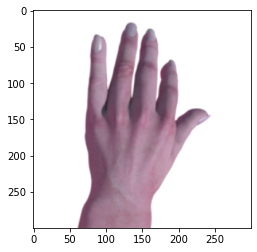

tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  258


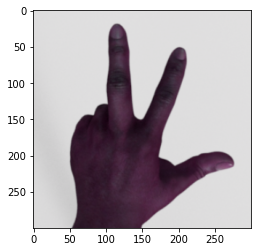

tf.Tensor([[0. 0. 1.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  260


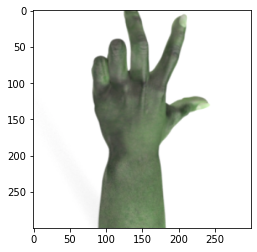

tf.Tensor([[0. 0. 1.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  261


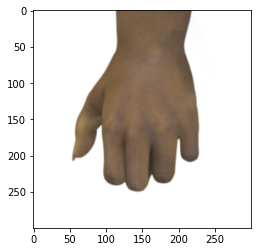

tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  241


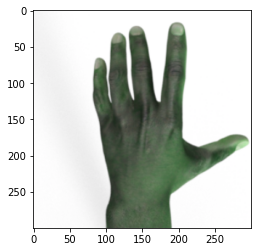

tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  253


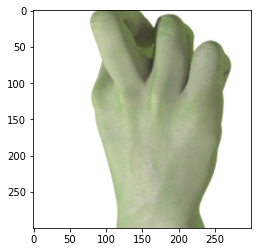

tf.Tensor([[1. 0. 0.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  252


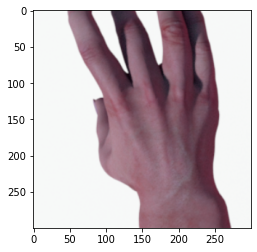

tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  248


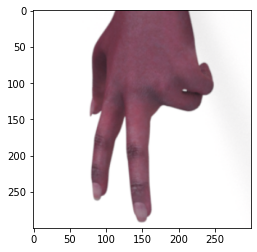

tf.Tensor([[0. 0. 1.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  242


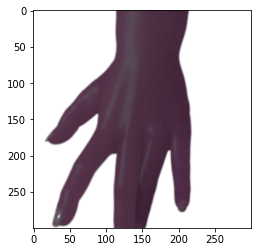

tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  264


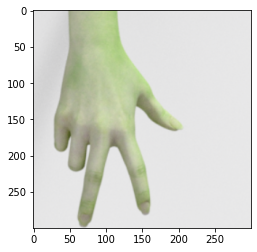

tf.Tensor([[0. 0. 1.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  250


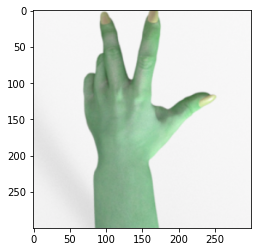

tf.Tensor([[0. 0. 1.]], shape=(1, 3), dtype=float32)
shape:  [300 300 3]
random value:  267


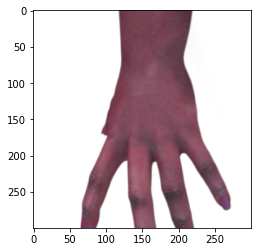

tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)


In [ ]:
# CELL 6
# More data pipe lines YAY!!!
'''
copy the pipeline above 

to the pipeline:
    - add a random flip
    - random hue, max alpha = 0.3
    - random brightness, max alpha = 0.3
    - random_contrast, min = 0.9, max = 1.1
'''
def preprocess(image: tf.Tensor, label: tf.Tensor, depth = 3, disp: bool = False):
    shape = tf.shape(image)
    image = tf.cast(image, dtype = tf.float32)
    image = image/255

    crop_1 = tf.cast(tf.shape(image)[0] * 22/28, dtype = tf.int32)
    crop_2 = tf.cast(tf.shape(image)[1] * 26/28, dtype = tf.int32)

    """
    copy code from previous pipeline but use crop_1 and crop_2 as the range within which to generate a random number
    """
    # preprocessed_image = tf.cast(image, dtype=tf.float32) # cast image to a float32 tensor
    # preprocessed_image = preprocessed_image / 255 # scaling all values to be between 0 and 1
    randint = tf.py_function(np.random.randint, [crop_1, crop_2], tf.int32) # generating a random number between 26 and 28
    image = tf.image.random_crop(image, size=(randint, randint, 3)) # applying a random crop
    # image = tf.image.resize(image, size=(28, 28)) # resizing the image to (28, 28, 1)

    # new additions
    if (tf.shape(image)[-1] == 3):
        """
        add:
            - random flip
            - random hue, max alpha = 0.3
            - random brightness, max alpha = 0.1
            - random_contrast, min = 0.9, max = 1.1
        """
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_hue(image, max_delta=0.3)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    image = tf.image.resize(image, (shape[0], shape[1]))
    label = tf.one_hot(label, depth)
    if disp:
        tf.print("shape: ", tf.shape(image))
        tf.print("random value: ", randint)
    return image, label

"""script to load data set and print info"""
(train, test), info = tfds.load("rock_paper_scissors", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
print(info)

""" Test """
train = train.map(lambda x, y: preprocess(x, y, disp = True)).batch(1)
for i, (image, label) in enumerate(train):
    if (tf.shape(image)[-1] != 3):
        plt.imshow(image[0, ..., 0])
    else:
        plt.imshow(image[0, ...])
    plt.show()
    print(label)
    if i > 10:
        break

In [ ]:
# CELL 7
model = ks.Sequential()
"""

BUILD A Conv NN: 

ADD LAYERS TO BUILD A FULL CNN
    - add layers to the sequential model using model.add(<the layer you choose>)
JUST MAKE SURE YOU USE SOFTMAX AS THE LAST LAYER, the soft max layer is provided

competition:
    - the student with the lowest number of parameters and accuracy >= 90% on the validation set will win $15
    - if multiple people have the same number of parameters, the money will be split between the winners, or it will go to the student with higher accuracy.

"""
model.add(ks.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(16, activation='relu'))
model.add(ks.layers.Dense(3))
model.add(ks.layers.Activation(activation = "softmax"))

model.build(input_shape=(None, 300, 300, 3))
model.summary()


"""script to load data set and print info"""
(train, test), info = tfds.load("rock_paper_scissors", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
train = train.map(lambda x, y: preprocess(x, y, disp = False)).batch(40)
test = test.map(lambda x, y: preprocess(x, y, disp = False)).batch(40)

EPOCHS = 100
optimizer = tf.keras.optimizers.Adam()
# I used the CategoricalCrossentropy function because after doing research,
# I learned that Cross Entropy loss functions are used for classification models
# and that is what the Rock-Paper-Scissors problem is supposed to do.
# Furthermore, I used Categorical because there were 3 labels in the one_hot 
# representation and that is what this loss function is used for.
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metrics_fn = ks.metrics.CategoricalAccuracy()

"""script that will be used to test you model"""
model.compile(optimizer=optimizer, loss = loss_fn, metrics=metrics_fn)
model.fit(train, validation_data = test, epochs=EPOCHS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 298, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 149, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 147, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 32)      

In [ ]:
# CELL 8
del model
model = ks.Sequential()
"""
COPY your model from above if you want this to test correctly
"""
model.add(ks.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(16, activation='relu'))
model.add(ks.layers.Dense(3))
model.add(ks.layers.Activation(activation = "softmax"))

(train, test), info = tfds.load("rock_paper_scissors", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
train = train.map(lambda x, y: preprocess(x, y, disp = False)).batch(40)
test = test.map(lambda x, y: preprocess(x, y, disp = False)).batch(40)

EPOCHS = 100
optimizer = ks.optimizers.Adam()
loss_fn = ks.losses.CategoricalCrossentropy()
metrics_fn = ks.metrics.CategoricalAccuracy()
loss_metrics_fn = ks.metrics.CategoricalCrossentropy()

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    """
    initialize something to hold all the values of loss and accuracy for validation and training
    """
    for x_batch_train, y_batch_train in train:
        """
        construct the training loop that would have been appied by calling model.fit
        """
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
      
        grads = tape.gradient(loss_value, model.trainable_weights)
        metrics_fn.update_state(y_batch_train, logits)
        loss_metrics_fn.update_state(y_batch_train, logits)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    accuracy = metrics_fn.result()
    loss = loss_metrics_fn.result()
    print(f"avg loss :: {loss}, avg accuracy :: {accuracy}", end = "\n")
    
    metrics_fn.reset_states()
    loss_metrics_fn.reset_states()

    for x_batch_test, y_batch_test in test: 
        """
        construct the validation loop that would be used to test if the accuracy is similar on the validation set
        """
        logits = model(x_batch_test, training=False)
        metrics_fn.update_state(y_batch_test, logits)
        loss_metrics_fn.update_state(y_batch_test, logits)

    val_accuracy = metrics_fn.result()
    val_loss = loss_metrics_fn.result()
    print(f"avg val loss :: {val_loss}, avg val accuracy :: {val_accuracy}", end = "\n")

    metrics_fn.reset_states()
    loss_metrics_fn.reset_states()




epoch: 0
avg loss :: 1.2682749032974243, avg accuracy :: 0.46984127163887024
avg val loss :: 0.9523228406906128, avg val accuracy :: 0.5537634491920471
epoch: 1
avg loss :: 0.6460587978363037, avg accuracy :: 0.7468253970146179
avg val loss :: 0.6776195764541626, avg val accuracy :: 0.7177419066429138
epoch: 2
avg loss :: 0.3966093063354492, avg accuracy :: 0.8579365015029907
avg val loss :: 0.5641371607780457, avg val accuracy :: 0.7634408473968506
epoch: 3
avg loss :: 0.48287081718444824, avg accuracy :: 0.8297619223594666
avg val loss :: 0.8308607339859009, avg val accuracy :: 0.6344085931777954
epoch: 4
avg loss :: 0.4697320759296417, avg accuracy :: 0.8230158686637878
avg val loss :: 0.621730387210846, avg val accuracy :: 0.7473118305206299
epoch: 5
avg loss :: 0.28887370228767395, avg accuracy :: 0.9003968238830566
avg val loss :: 0.4718964397907257, avg val accuracy :: 0.8037634491920471
epoch: 6
avg loss :: 0.29722562432289124, avg accuracy :: 0.8996031880378723
avg val loss ::

In [ ]:
# CELL 9
"""visualize/ test the trained model"""
(train, test), info = tfds.load("rock_paper_scissors", split = ['train', 'test'], with_info=True, shuffle_files=True, as_supervised = True)
test = test.map(lambda x, y: preprocess(x, y, disp = False)).batch(1)

class_dict = {0:"rock", 1:"paper", 2:"scissors"}
for i, (image, label) in enumerate(test):
    classif = model(image)
    if (tf.shape(image)[-1] != 3):
        plt.imshow(image[0, ..., 0])
    else:
        plt.imshow(image[0, ...])
    plt.show()
    print(class_dict[int(tf.math.argmax(classif, axis = -1)[0])], class_dict[int(tf.math.argmax(label, axis = -1)[0])])

    if i > 10:
        break

In [ ]:
# CELL 10
""" Read the TFMG Tech Report (https://arxiv.org/abs/2107.00821) and answer the following questions)

1. What is the purpose of the Tensorflow Model Garden?
The purpose of the Tensorflow Model Garden is to increase the standardization of ML models through the creation of
a collection of exemplars which will aid the advancements in science and engineering. Its work fills the gap in 
industry and academic knowledge.

2. How does this team's goals differ from those of NeurIPS?
NeurIPS focuses on encouraging and promoting the importance of reproducability of academic papers. However, their
interests do not lie in helping engineers reproduce implementations, but rather other experts and researchers.
This team's goal is to communicate this implicit expert knowledge for engineers to use in practice.

3. Explain the difference between a custom layer and a custom block.
A custom layer is a layer which is not predefined in TensorFlow and perform a specific function. On the other hand, 
a custom layer is a set of layers that are repeatedly seen within a model architecture and are not predefined either.

4. Explain the importance of training and evaluation checks.
Training and evaluation checks are important to ensure that the exemplars are indeed exemplary implementations and 
reproductions of the academic papers by matching the dataset used, pre-processing functions, output processing 
functions, testing and target metrics and training steps with the original implementation.

5. Which folder would a custom layer belong in according to the Tensorflow Model Garden organizational structure?
A custom layer belong in the modeling folder according to the Tensorflow Model Garden organizational structure.

6. Why is metric evaluation alone not sufficient to confirm that a model has been successfully reimplemented?
Metric evaluation alone is not sufficient to confirm that a model has been successfull reimplemented because it 
only provides information about aggregate perfomance when comparing to the original implementation. This does not imply
identical results from the model, only a rough estimate. More direct and involved testing is, therefore, required.

7. What TensorFlow function should be used when computing values whose gradients can be safely ignored?
The tf.stop gradient function should be used when computing values whose gradients can be safely ignored.

8. Describe the purpose of the datapipeline and its 3 components.
The purpose of the datapipeline is to go from raw data to data suitable for the model and achieves this through its 3 components:
Decoder - It extracts raw data from a storage source and converts it to a format compatible with the rest of the pipeline.
Parser - It transforms (preprocessing, normalizing, formatting) the data into the required input format for the model.
Loader - It loads the transformed data into the model for training.
"""

" Read the TFMG Tech Report (https://arxiv.org/abs/2107.00821) and answer the following questions)\n\n1. What is the purpose of the Tensorflow Model Garden?\nThe purpose of the Tensorflow Model Garden is to increase the standardization of ML models through the creation of\na collection of exemplars which will aid the advancements in science and engineering. Its work fills the gap in \nindustry and academic knowledge.\n\n2. How does this team's goals differ from those of NeurIPS?\nNeurIPS focuses on encouraging and promoting the importance of reproducability of academic papers. However, their\ninterests do not lie in helping engineers reproduce implementations, but rather other experts and researchers.\nThis team's goal is to communicate this implicit expert knowledge for engineers to use in practice.\n\n3. Explain the difference between a custom layer and a custom block.\nA custom layer is a layer which is not predefined in TensorFlow and perform a specific function. On the other hand,